In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from urllib.parse import unquote
from tqdm import tqdm 
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot

dataFolder = '../Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header=11, sep = '\t')
linksDf.columns = ['Elements','links']
linksDf['Elements'] = linksDf['Elements'].map(lambda x : unquote(x, 'utf-8'))
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
#linksDf.reset_index()

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#paths_finishedDf

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf

people_skin_color = pd.read_csv(dataFolder + 'ethnic_category.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : unquote(x, 'utf-8'))
people_skin_color.reset_index()
people_skin_color

FileNotFoundError: [Errno 2] No such file or directory: '../Data/wikispeedia_paths-and-graph/ethnic_category.tsv'

In [ ]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color'].unique()
rename = {
    'Blanc' : 'White',
    'Peau plus foncée' : 'Black',
    'Peau brune' : 'Black',
    'Peau plus foncée (Aborigène australien)' : 'Black',
    'Peau plus foncée (Asiatique)' : 'East Asian', 
    'Peau plus foncée (Moyen-Orient)' : 'Arab',
    'Peau plus foncée (Polynésien)' : 'Polynesian',
    'Peau plus foncée (Sherpa/Népalais)' : 'South Asian', 
    'Peau plus foncée (Ascendance africaine partielle)' : 'Black', 
    'Peau plus foncée (Indien)' : 'South Asian',
    'Peau plus foncée (Berbère)' : 'Arab',
    'Peau plus foncée (Arabe)' : 'Arab',
    'Peau plus foncée (Tibétain)' : 'East Asian',
    'Peau plus foncée (Persan)' : 'Arab',
    'Peau plus foncée (Juif)' : 'Arab', 
    'Peau plus foncée (Somalienne)' : 'Black', 
    'Peau plus foncée (Mixte)' : 'Black',
    'Peau plus foncée (Hispanique)' : 'Hispanic', 
    'Peau plus foncée (Indonésien)' : 'East Asian', 
    'Peau plus foncée (Japonais)' : 'East Asian',
    'Peau plus foncée (Vietnamien)' : 'East Asian', 
    'Peau plus foncée (Indienne)' : 'South Asian', 
    'Peau brune (Indien)' : 'South Asian',
    'Peau plus foncée (Palestinien)' : 'Arab',
    'Peau brune (Pakistano-Indien)' : 'South Asian', 
    "Blanc (D'origine libanaise)": 'White', 
    'Peau plus foncée (Brésilien)' : 'Hispanic'
}
people_color['Skin Color'] = people_color['Skin Color'].replace(rename)
people_color_dist=people_color['Skin Color'].value_counts()
print(people_color.head(50))


                                        People Skin Color                   2
0                        Óengus I of the Picts      White  Historical_figures
1                            Abbas I of Persia      Black  Historical_figures
2                                   Adam Smith      White  Historical_figures
3                        Adriaen van der Donck      White  Historical_figures
4                                    Agamemnon      White  Historical_figures
5                                        Akbar      Black  Historical_figures
6                                    Akhenaten      Black  Historical_figures
7                                   Alcibiades      White  Historical_figures
8                           Aleksey Arakcheyev      White  Historical_figures
9                           Alexander Hamilton      White  Historical_figures
10                                Amda Seyon I      Black  Historical_figures
11  Armand Jean du Plessis, Cardinal Richelieu      White  Histo

In [ ]:
# création d'un dataframe dont le but sera de garder seulement les pages wikipedia de personnes et les liens vers d'autres personnes:
people_links= linksDf

# On enlève tous les accents et espaces des dataframe people_color (contenant toutes les personnes et leur ethnie) et people_links
# (contenant toutes les pages wikipedia et leurs liens) pour pouvoir les comparer:
people_color.People= people_color.People.str.replace(' ', '_')
people_color.People= people_color.People.apply(unidecode)
people_links.Elements= people_links.Elements.apply(unidecode)

# On supprime toutes les pages wikipedia qui ne sont pas des personnes (colonne 'Elements'): 
indices_to_delete=[]
for i in range (0,len(people_links)): 
    if people_links['Elements'][i] not in people_color.People.values: 
        indices_to_delete=indices_to_delete + [i]
people_links= people_links.drop(indices_to_delete)
people_links=people_links.reset_index(drop=True)


In [ ]:
print(people_links)
# jonah lomu, le seul polynésien, est enlevé du dataframe car aucun lien sur sa page wikipedia n'emmène vers d'autres personnes

            Elements            links
0      Edouard_Manet         Absinthe
1      Edouard_Manet             Beer
2      Edouard_Manet     Claude_Monet
3      Edouard_Manet  Diego_Velázquez
4      Edouard_Manet  Edgar_Allan_Poe
...              ...              ...
16396      Zoroaster             Star
16397      Zoroaster       Tajikistan
16398      Zoroaster     Turkmenistan
16399      Zoroaster         Voltaire
16400      Zoroaster             Zeus

[16401 rows x 2 columns]


In [ ]:
# On supprime tous les liens qui ne sont pas des personnes (colonne 'links'): 
indices_to_delete=[]
for i in range (0,len(people_links)): 
    if people_links['links'][i] not in people_color.People.values: 
        indices_to_delete=indices_to_delete + [i]
people_links= people_links.drop(indices_to_delete)
people_links=people_links.reset_index(drop=True)
print(people_links)
print(people_color)

           Elements                links
0     Edouard_Manet         Claude_Monet
1     Edouard_Manet      Edgar_Allan_Poe
2     Edouard_Manet       Francisco_Goya
3     Edouard_Manet              Raphael
4       Abel_Tasman           James_Cook
...             ...                  ...
2999      Zoroaster  Friedrich_Nietzsche
3000      Zoroaster                Jesus
3001      Zoroaster             Muhammad
3002      Zoroaster                Plato
3003      Zoroaster             Voltaire

[3004 rows x 2 columns]
                    People Skin Color                   2
0    Oengus_I_of_the_Picts      White  Historical_figures
1        Abbas_I_of_Persia      Black  Historical_figures
2               Adam_Smith      White  Historical_figures
3    Adriaen_van_der_Donck      White  Historical_figures
4                Agamemnon      White  Historical_figures
..                     ...        ...                 ...
706            Jimmy_Wales      White    Computing_People
707         Linus_T

In [ ]:
# On veut connaitre l'ethnie de toutes les personnes des pages wikipedia ('E_color') et celle des personnes en lien ('l_color'):
E_color = []
l_color = []
for i in range (0, len(people_links)):
    for j in range (0, len(people_color)):
        if people_links['Elements'][i]== people_color['People'][j]:
            # prend la couleur de la personne
            E_color= E_color+ [people_color['Skin Color'][j]]
            break      
    for k in range (0, len(people_color)):
        if people_links['links'][i]== people_color['People'][k]:
            # prend la couleur de la personne
            l_color= l_color+ [people_color['Skin Color'][k]]
            break 

In [ ]:
people_links['E_color']= E_color
people_links['l_color']= l_color
print(people_links.head(50))
print(len(people_links))
# On obtient quelques NaN qu'il va falloir ajuster, sinon c'est cramer qu'on a fait ca avec l'IA 

             Elements                     links      E_color     l_color
0       Edouard_Manet              Claude_Monet          NaN       White
1       Edouard_Manet           Edgar_Allan_Poe          NaN       White
2       Edouard_Manet            Francisco_Goya          NaN       White
3       Edouard_Manet                   Raphael          NaN       White
4         Abel_Tasman                James_Cook        White       White
5   Abraham_Goldfaden              George_Eliot        White       White
6   Abraham_Goldfaden       William_Shakespeare        White       White
7     Abraham_Lincoln            Andrew_Johnson        White       White
8     Abraham_Lincoln            Charles_Darwin        White       White
9     Abraham_Lincoln            Charles_Sumner        White       White
10    Abraham_Lincoln        Frederick_Douglass        White       Black
11    Abraham_Lincoln            James_Buchanan        White       White
12    Abraham_Lincoln             James_K._Polk    

In [ ]:
# À présent, on veut connaitre le nombre de pages wikipedia de personnes d'une certaine ethnie qui emmène vers une autre ethnie 
# par exemple le nombre de pages wikipedia d'une personne noire qui emmenne vers une personne arabe = 7 
ethni_pair = people_links.groupby(['E_color', 'l_color']).size().reset_index(name='nb_links')
print(ethni_pair)

        E_color      l_color  nb_links
0          Arab         Arab        11
1          Arab        Black         3
2          Arab   East Asian         4
3          Arab  South Asian         1
4          Arab        White        22
5         Black         Arab         7
6         Black        Black        46
7         Black   East Asian         2
8         Black     Hispanic         4
9         Black  South Asian         6
10        Black        White        97
11   East Asian         Arab         1
12   East Asian        Black         3
13   East Asian   East Asian        13
14   East Asian  South Asian         6
15   East Asian        White        38
16     Hispanic         Arab         1
17     Hispanic        Black         4
18     Hispanic     Hispanic         1
19     Hispanic        White        12
20  South Asian         Arab         1
21  South Asian        Black         4
22  South Asian   East Asian         3
23  South Asian  South Asian         3
24  South Asian        Wh

In [ ]:
print(ethni_pair.nb_links.sum())
# On voit que 49 pages n'ont pas de liens vers d'autres personnes, et que les autres personnes n'ont pas de liens menant vers cette page 

2929


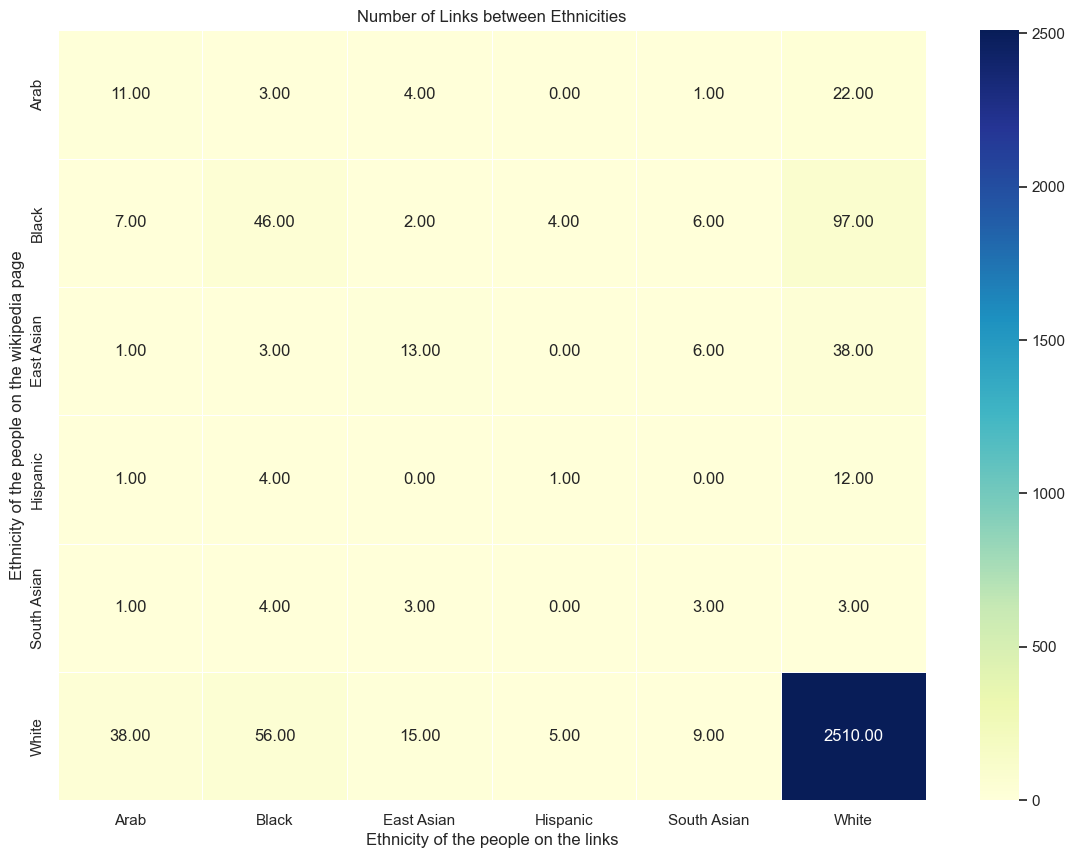

In [ ]:
# Pivot the DataFrame for heatmap
heatmap_matrix = ethni_pair.pivot_table(values='nb_links', index='E_color', columns='l_color', fill_value=0)

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)

# Set plot title and labels
plt.title('Number of Links between Ethnicities')
plt.xlabel('Ethnicity of the people on the links')
plt.ylabel('Ethnicity of the people on the wikipedia page')

# Show the plot
plt.show()

In [ ]:
# Pour avoir quelque chose de moins biaisé, on va chercher a connaitre la proportion de lien entre chaque ethnie. Pour cela on divise 
# chaque pair de liens par le nombre total de liens que possède les pages wikipedia de personnes d'une certaine ethnie.  
# Ce qui nous donne: 

links_per_ethni= ethni_pair.groupby(['E_color']).sum().reset_index()
print(links_per_ethni)
ethni_pair['nb_links_reajust']= ethni_pair.nb_links
for i in range (0, len(links_per_ethni)):
    for j in range (0, len(ethni_pair)):
        if ethni_pair['E_color'][j]== links_per_ethni['E_color'][i]: 
            ethni_pair['nb_links_reajust'][j]= ethni_pair['nb_links'][j]/links_per_ethni['nb_links'][i]

print(ethni_pair)
# nickel, maintenant comment on fait pour prendre en compte le fait qu'on a beaucoup plus de chance d'arriver 
# sur la page d'un blanc aussi, simplement parce qu'il y a plus de blanc dans le jeu? --> normaliser l_color en gros

       E_color                                      l_color  nb_links
0         Arab          ArabBlackEast AsianSouth AsianWhite        41
1        Black  ArabBlackEast AsianHispanicSouth AsianWhite       162
2   East Asian          ArabBlackEast AsianSouth AsianWhite        61
3     Hispanic                       ArabBlackHispanicWhite        18
4  South Asian          ArabBlackEast AsianSouth AsianWhite        14
5        White  ArabBlackEast AsianHispanicSouth AsianWhite      2633
        E_color      l_color  nb_links  nb_links_reajust
0          Arab         Arab        11          0.268293
1          Arab        Black         3          0.073171
2          Arab   East Asian         4          0.097561
3          Arab  South Asian         1          0.024390
4          Arab        White        22          0.536585
5         Black         Arab         7          0.043210
6         Black        Black        46          0.283951
7         Black   East Asian         2          0.0123

/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_92354/2024854410.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethni_pair['nb_links_reajust'][j]= ethni_pair['nb_links'][j]/links_per_ethni['nb_links'][i]
/var/folders/qv/jxqksgr511n2kd5_v801s5vc0000gn/T/ipykernel_92354/2024854410.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2682926829268293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ethni_pair['nb_links_reajust'][j]= ethni_pair['nb_links'][j]/links_per_ethni['nb_links'][i]


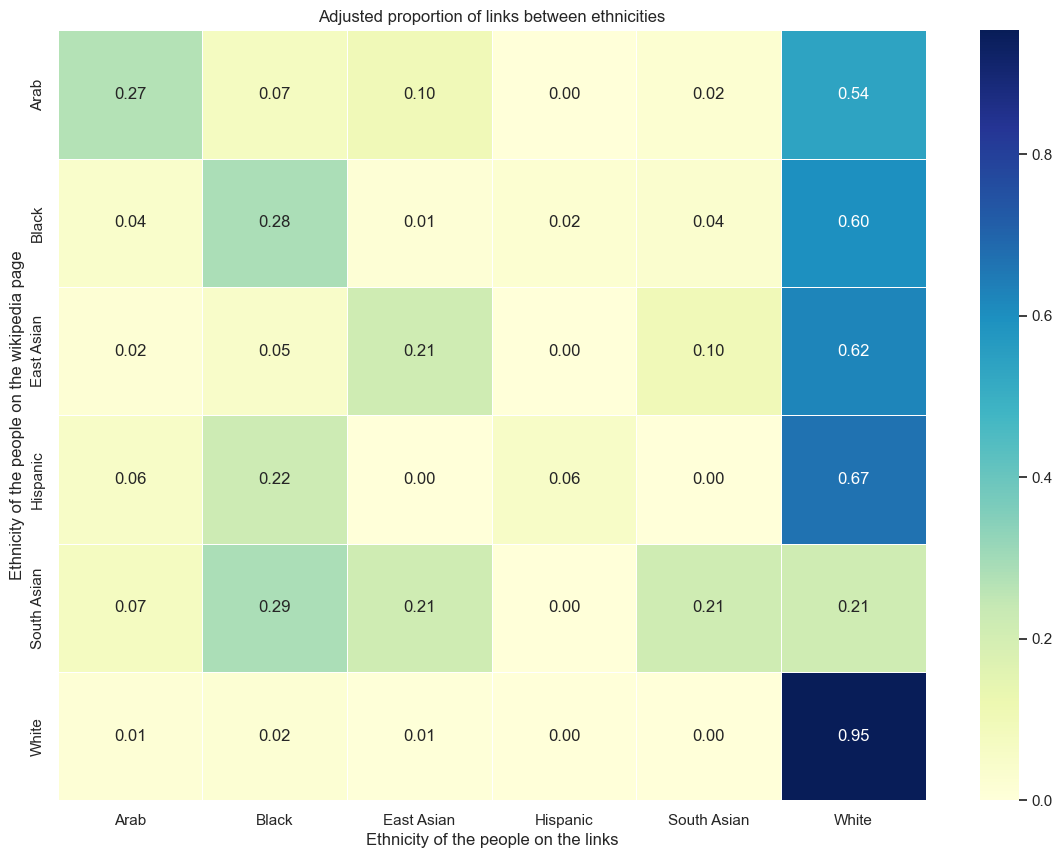

In [ ]:
# Pivot the DataFrame for heatmap
heatmap_matrix = ethni_pair.pivot_table(values='nb_links_reajust', index='E_color', columns='l_color', fill_value=0)

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)

# Set plot title and labels
plt.title('Adjusted proportion of links between ethnicities')
plt.xlabel('Ethnicity of the people on the links')
plt.ylabel('Ethnicity of the people on the wikipedia page')

# Show the plot
plt.show()